<a href="https://colab.research.google.com/github/Korsholm22/M4_Group_Assignments/blob/main/Group_Assignment_2/Group_Assignment_2_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**TASK**
- Build, train, and evaluate 2 special types of networks neural network with Pytorch.
  - A CNN for a spatial prediction problem
  - **A RNN or LSTM for a sequential problem**
- Experiment with at least 2 different variations of hyperparameters for each network.
- Optional: Use gradio to build a simple interactive demo (in the notebook).

This should include:

1. Feature selection and/or engineering (if necessary)
2. Preprocessing (if necessary)
3. Train-test split
4. Defining a neural network architecture in putorch
5. Define a training loop
6. Training the model
7. Try out different hyperparameters
8. Evaluate the final model on the test data
9. Optional: Visualize results with Grad.io

# LSTM

# Imports

In [1]:
# Importing libraries
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# Importing weather dataset in zip format
!curl https://www.bgc-jena.mpg.de/wetter/mpi_saale_2021b.zip -o mpi_saale_2021b.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1486k  100 1486k    0     0   468k      0  0:00:03  0:00:03 --:--:--  468k


In [3]:
# Extracting dataset from zip to a pandas dataframe
zip_file = zipfile.ZipFile("mpi_saale_2021b.zip")
zip_file.extractall()
csv_path = "mpi_saale_2021b.csv"
df = pd.read_csv(csv_path)

In [4]:
# Examining the dataset
df.head()

,Date Time,p (mbar),T (degC),rh (%),sh (g/kg),Tpot (K),Tdew (degC),VPmax (mbar),VPact (mbar),VPdef (mbar),...,ST008 (degC),ST016 (degC),ST032 (degC),ST064 (degC),ST128 (degC),SM008 (%),SM016 (%),SM032 (%),SM064 (%),SM128 (%)
0,01.07.2021 00:10:00,994.66,15.30,88.0,9.64,288.89,13.33,17.41,15.32,2.09,...,19.71,20.04,19.46,17.47,14.14,24.74,21.69,23.17,26.47,32.96
1,01.07.2021 00:20:00,994.60,15.16,89.9,9.76,288.76,13.52,17.26,15.51,1.74,...,19.67,20.02,19.46,17.47,14.14,24.74,21.69,23.17,26.47,32.95
2,01.07.2021 00:30:00,994.56,15.18,90.9,9.88,288.78,13.71,17.28,15.71,1.57,...,19.64,20.00,19.45,17.47,14.14,24.74,21.69,23.17,26.47,32.95
3,01.07.2021 00:40:00,994.55,15.73,86.7,9.76,289.33,13.52,17.90,15.52,2.38,...,19.61,19.98,19.45,17.47,14.14,24.73,21.69,23.17,26.47,32.95
4,01.07.2021 00:50:00,994.58,16.18,84.3,9.77,289.78,13.53,18.42,15.53,2.89,...,19.57,19.96,19.45,17.46,14.14,24.73,21.69,23.17,26.47,32.95


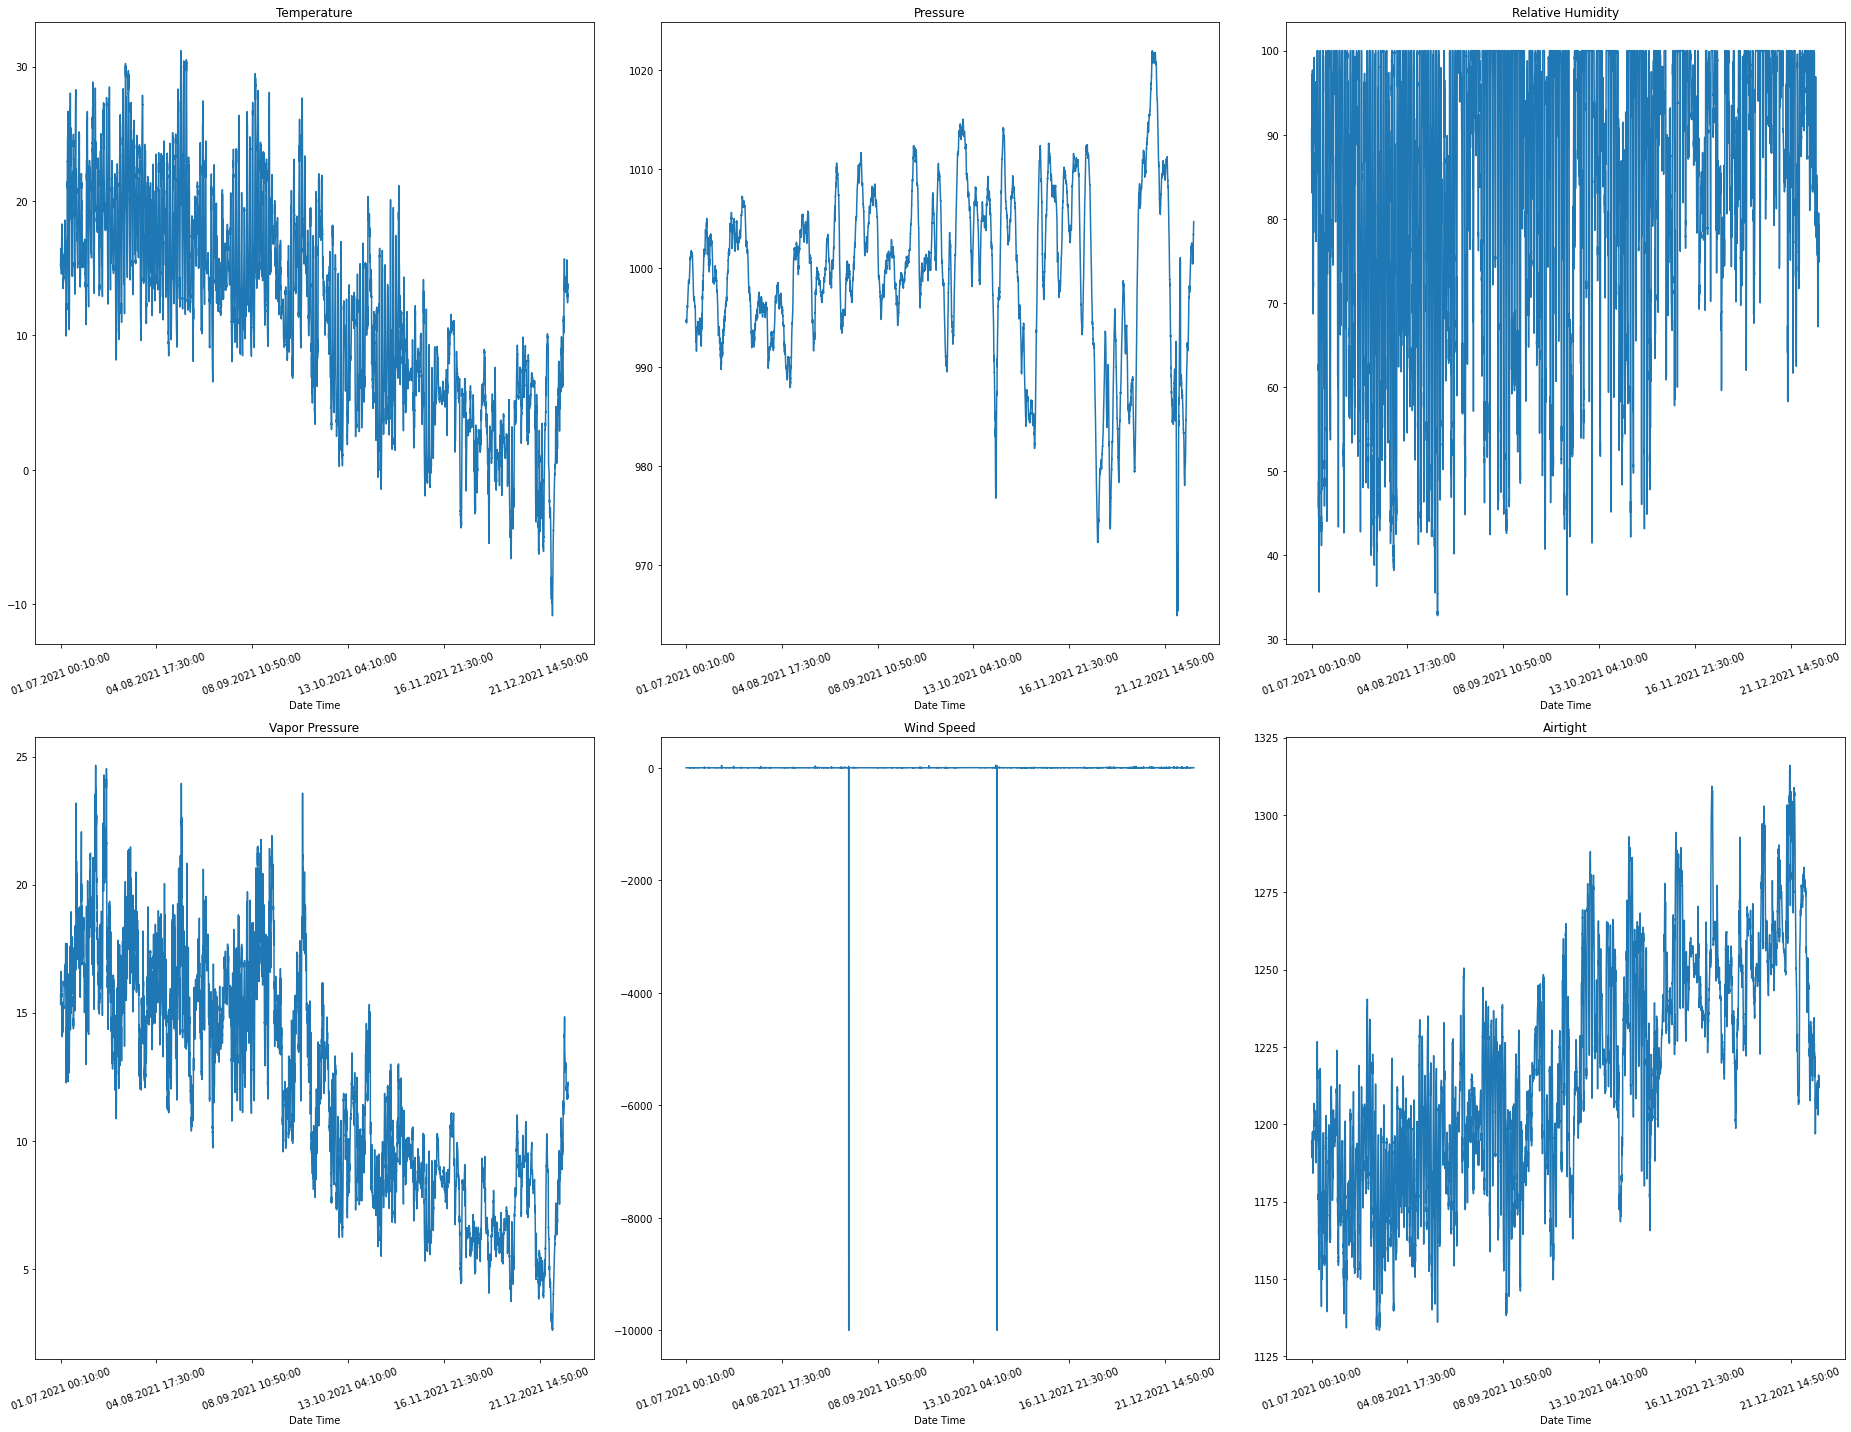

In [5]:
# Plotting selected features over time
plt.subplots(nrows=2, ncols=3, figsize=(26, 20))

# Features
time = df['Date Time']
temperature = df['T (degC)']
pressure = df['p (mbar)']
relative_humidity = df['rh (%)']
vapor_pressure = df['VPact (mbar)']
wind_speed = df['wv (m/s)']
airtight = df['rho (g/m**3)']

# Plots
ax = plt.subplot(2, 3, 1)
temperature.index = time
temperature.head()
temperature.plot(rot=20)
plt.title('Temperature')

ax = plt.subplot(2, 3, 2)
pressure.index = time
pressure.head()
pressure.plot(rot=20)
plt.title('Pressure')

ax = plt.subplot(2, 3, 3)
relative_humidity.index = time
relative_humidity.head()
relative_humidity.plot(rot=20)
plt.title('Relative Humidity')

ax = plt.subplot(2, 3, 4)
vapor_pressure.index = time
vapor_pressure.head()
vapor_pressure.plot(rot=20)
plt.title('Vapor Pressure')

ax = plt.subplot(2, 3, 5)
wind_speed.index = time
wind_speed.head()
wind_speed.plot(rot=20)
plt.title('Wind Speed')

ax = plt.subplot(2, 3, 6)
airtight.index = time
airtight.head()
airtight.plot(rot=20)
plt.title('Airtight')

plt.tight_layout()
plt.show()

# Preprocessing and Feature Engineering

In [6]:
# Converting the column 'Date Time' from an object to datetime and setting it as index
df['Date Time']= pd.to_datetime(df['Date Time'])
df = df.set_index('Date Time')

In [7]:
# Downsampling the dataset from 10 minute intervals to hourly intervals
df = df.resample('H').mean().dropna()

In [8]:
# Selecting features to be used in the LSTM network and defining X and y
X = df[['p (mbar)', 'rh (%)', 'VPact (mbar)', 'wv (m/s)','rho (g/m**3)']]
y = pd.DataFrame(df['T (degC)'])

In [9]:
# Scaling the data
ss = StandardScaler()
mm = MinMaxScaler()

X_ss = ss.fit_transform(X)
y_mm = mm.fit_transform(y) 

In [10]:
# Splitting the data into training and test sets (approx. 80% for training and 20% for testing)
X_train = X_ss[:3500, :]
X_test = X_ss[3500:, :]

y_train = y_mm[:3500, :]
y_test = y_mm[3500:, :] 

In [11]:
# Examining the size of the training and test sets
print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape) 

Training Shape (3500, 5) (3500, 1)
Testing Shape (917, 5) (917, 1)


In [12]:
# Splitting the data into training and test sets using TensorDataset and DataLoader
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

# Training and Testing the Models

The models are tested in the following sections with different variations of hyperparameters, including hidden size, number of epochs, loss function, optimization function and learning rate.

## Experiment 1

Hyperparameters:
- Hidden size = 16
- Number of epochs = 10
- Loss function = MSE Loss
- Optimization algorithm = SGD
- Learning rate = 0.01

In [13]:
# Initialize the LSTM model
# Define the input size, hidden size and number of outputs
input_size = 5
hidden_size = 16
output_size = 1
num_epochs= 10

# Define the LSTM model and Linear output fully connected layer
lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
fc = nn.Linear(hidden_size, output_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(lstm.parameters(), lr=0.01)

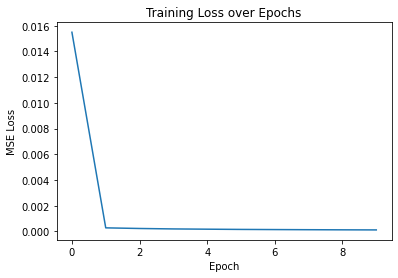

In [14]:
# Initializing Hyperparameters
train_losses = []
test_losses = []

# Loop over the number of epochs
for epoch in range(num_epochs):
    train_loss = 0
    # Initialize the hidden state and the cell state
    # The hidden state and the cell state reset to zero for every epoch
    hs = torch.zeros(1, hidden_size)
    cs = torch.zeros(1, hidden_size)

    # Get the input and target at position i
    for i, (data, label) in enumerate(train_loader):
        
        hidden = (hs, cs)
        # Run the forward pass
        output, hidden = lstm(data.float(), hidden)
        output = fc(hidden[-1])
        hs = hs.detach()
        cs = cs.detach()

        # 2. Network Evaluation
        loss = criterion(output, label.float())

        # 3. Gradient Calculation
        loss.backward()

        # 4. Back Propagation
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()

    # Calculate the average training loss
    train_loss = train_loss / len(train_loader)
    train_losses.append(train_loss)

# Plot the MSE loss for each epoch
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss over Epochs')
plt.show()

In [15]:
# Evaluate the LSTM model
mse = 0

#By wrapping the evaluation code in a with torch.no_grad() context, 
#you can avoid unnecessary memory usage and speed up the evaluation process.
with torch.no_grad():
    # Initialize the hidden state and the cell state
    # The hidden state and the cell state reset to zero for every epoch
    hs = torch.zeros(1, hidden_size)
    cs = torch.zeros(1, hidden_size)

    for data, label in test_loader:
        hidden = (hs, cs)
        output, hidden = lstm(data.float(), hidden)
        output = fc(hidden[-1])
        hs = hs.detach()
        cs = cs.detach()
        
        mse += ((output - label)**2).mean().item()

mse /= len(test_loader)
print('Test MSE: {}'.format(mse))

Test MSE: 0.00035944264054898605


In [16]:
output_list = []

# Initialize the hidden state and the cell state
# The hidden state and the cell state reset to zero for every epoch
hs = torch.zeros(1, hidden_size)
cs = torch.zeros(1, hidden_size)
for i, (data, label) in enumerate(test_loader):
    hidden = (hs, cs)
    
    # Run the forward pass
    output, hidden = lstm(data.float(), hidden)
    output = fc(hidden[-1])
    hs = hs.detach()
    cs = cs.detach()
    output_list.append(output.detach().numpy()[0][0])
    
for i, (data, label) in enumerate(train_loader):
    hidden = (hs, cs)

    # Run the forward pass
    output, hidden = lstm(data.float(), hidden)
    output = fc(hidden[-1])
    hs = hs.detach()
    cs = cs.detach()
    output_list.append(output.detach().numpy()[0][0])

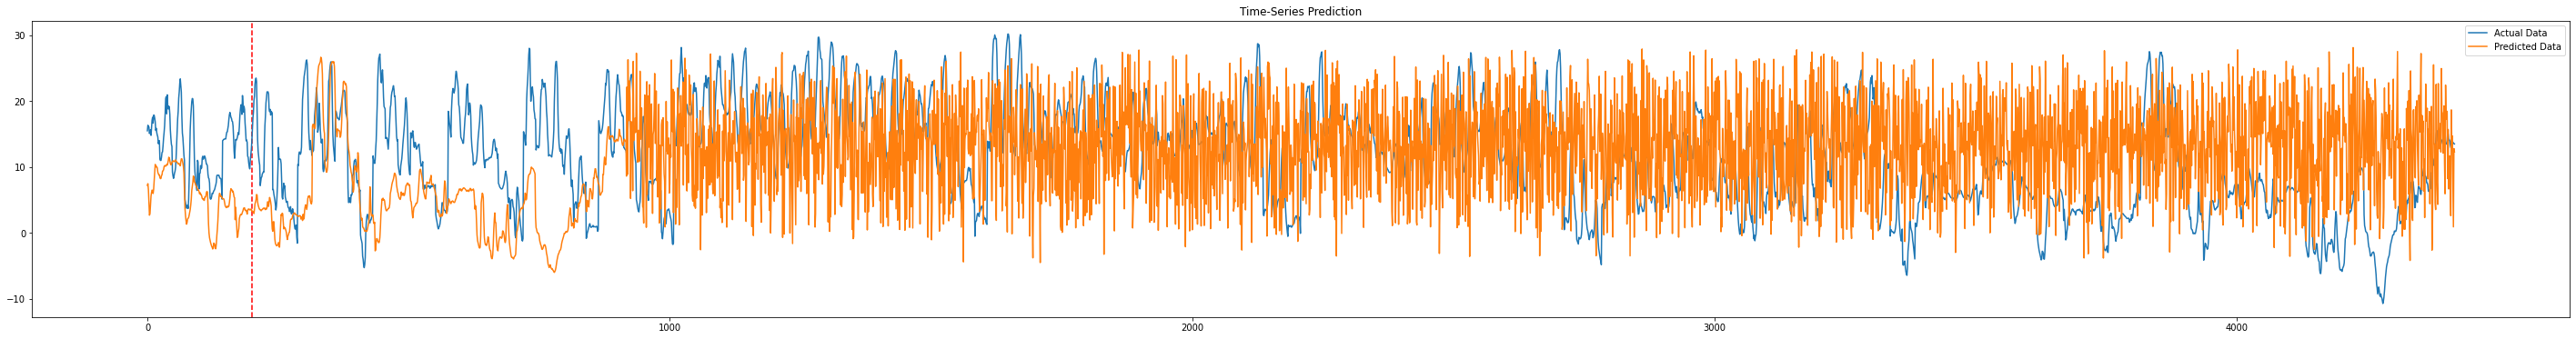

In [17]:
# Plotting the actual values vs. the predicted values
dataY_plot = y['T (degC)'].values
data_predict = mm.inverse_transform([output_list]) #reverse transformation
plt.figure(figsize=(50,6)) #plotting
plt.axvline(x=200, c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actual Data') #actual plot
plt.plot(data_predict[0], label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 

In [18]:
# Save the trained LSTM model
torch.save(lstm.state_dict(), 'lstm_exp_1.pt')

# Load the model
lstm_exp_1 = nn.LSTM(input_size, hidden_size, batch_first=True)
lstm_exp_1.load_state_dict(torch.load('lstm_exp_1.pt'))

<All keys matched successfully>

## Experiment 2

Hyperparameters:
- Hidden size = 40
- Number of epochs = 40
- Loss function = MSE Loss
- Optimization algorithm = SGD
- Learning rate = 0.001


In [19]:
# Initialize the LSTM model
# Define the input size, hidden size and number of outputs
input_size = 5
hidden_size = 40
output_size = 1
num_epochs= 40

# Define the LSTM model and Linear output fully connected layer
lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
fc = nn.Linear(hidden_size, output_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(lstm.parameters(), lr=0.001)

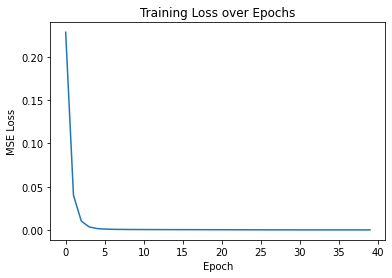

In [20]:
# Initializing Hyperparameters
train_losses = []
test_losses = []

# Loop over the number of epochs
for epoch in range(num_epochs):
    train_loss = 0
    # Initialize the hidden state and the cell state
    # The hidden state and the cell state reset to zero for every epoch
    hs = torch.zeros(1, hidden_size)
    cs = torch.zeros(1, hidden_size)

    # Get the input and target at position i
    for i, (data, label) in enumerate(train_loader):
        
        hidden = (hs, cs)
        # Run the forward pass
        output, hidden = lstm(data.float(), hidden)
        output = fc(hidden[-1])
        hs = hs.detach()
        cs = cs.detach()

        # 2. Network Evaluation
        loss = criterion(output, label.float())

        # 3. Gradient Calculation
        loss.backward()

        # 4. Back Propagation
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()

    # Calculate the average training loss
    train_loss = train_loss / len(train_loader)
    train_losses.append(train_loss)

# Plot the MSE loss for each epoch
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss over Epochs')
plt.show()

In [21]:
# Evaluate the LSTM model
mse = 0

#By wrapping the evaluation code in a with torch.no_grad() context, 
#you can avoid unnecessary memory usage and speed up the evaluation process.
with torch.no_grad():
    # Initialize the hidden state and the cell state
    # The hidden state and the cell state reset to zero for every epoch
    hs = torch.zeros(1, hidden_size)
    cs = torch.zeros(1, hidden_size)

    for data, label in test_loader:
        hidden = (hs, cs)
        output, hidden = lstm(data.float(), hidden)
        output = fc(hidden[-1])
        hs = hs.detach()
        cs = cs.detach()
        
        mse += ((output - label)**2).mean().item()

mse /= len(test_loader)
print('Test MSE: {}'.format(mse))

Test MSE: 0.00023884346224721544


In [22]:
output_list = []

# Initialize the hidden state and the cell state
# The hidden state and the cell state reset to zero for every epoch
hs = torch.zeros(1, hidden_size)
cs = torch.zeros(1, hidden_size)
for i, (data, label) in enumerate(test_loader):
    hidden = (hs, cs)
    
    # Run the forward pass
    output, hidden = lstm(data.float(), hidden)
    output = fc(hidden[-1])
    hs = hs.detach()
    cs = cs.detach()
    output_list.append(output.detach().numpy()[0][0])
    
for i, (data, label) in enumerate(train_loader):
    hidden = (hs, cs)

    # Run the forward pass
    output, hidden = lstm(data.float(), hidden)
    output = fc(hidden[-1])
    hs = hs.detach()
    cs = cs.detach()
    output_list.append(output.detach().numpy()[0][0])

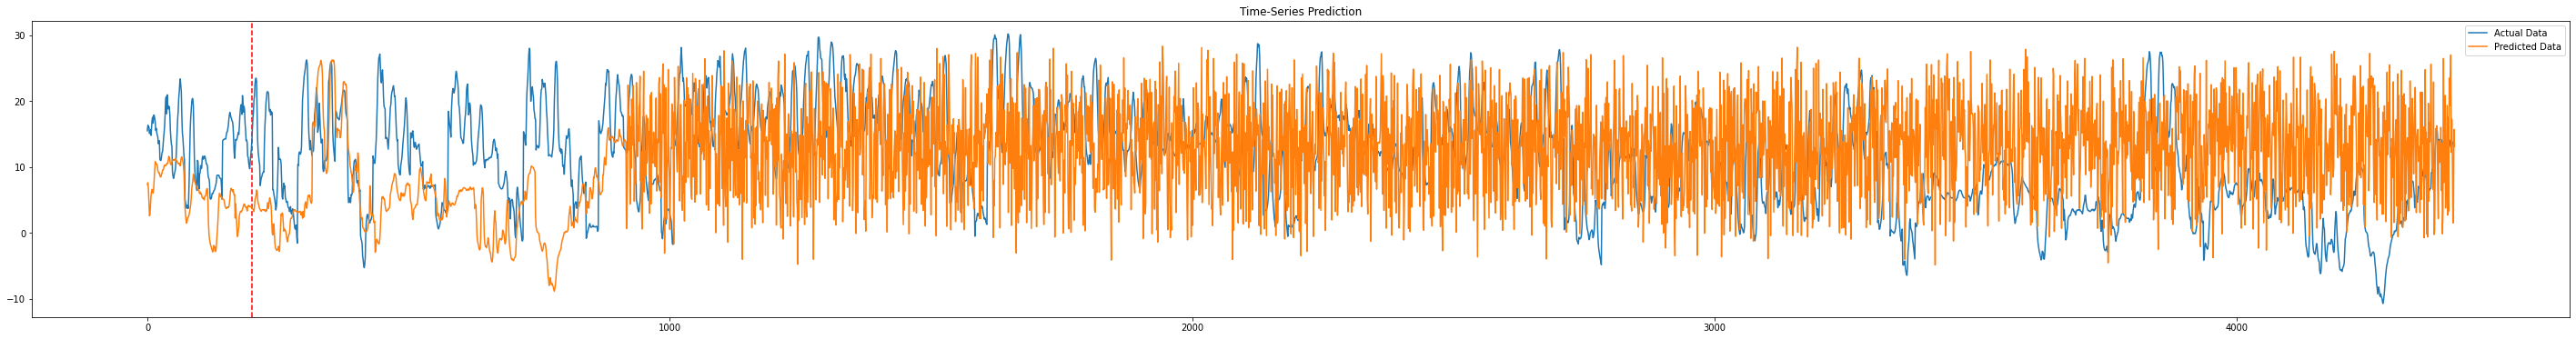

In [23]:
dataY_plot = y['T (degC)'].values
data_predict = mm.inverse_transform([output_list]) #reverse transformation
plt.figure(figsize=(50,6)) #plotting
plt.axvline(x=200, c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actual Data') #actual plot
plt.plot(data_predict[0], label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 

In [24]:
# Save the trained RNN model
torch.save(lstm.state_dict(), 'lstm_exp_2.pt')

# Load the model
lstm_exp_2 = nn.LSTM(input_size, hidden_size, batch_first=True)
lstm_exp_2.load_state_dict(torch.load('lstm_exp_2.pt'))

<All keys matched successfully>

## Experiment 3

Hyperparameters:
- Hidden size = 20
- Number of epochs = 25
- Loss function = MSE Loss
- Optimization algorithm = Adam
- Learning rate = 0.001


In [25]:
# Initialize the LSTM model
# Define the input size, hidden size and number of outputs
input_size = 5
hidden_size = 20
output_size = 1
num_epochs= 25

# Define the LSTM model and Linear output fully connected layer
lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
fc = nn.Linear(hidden_size, output_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(lstm.parameters(), lr=0.001)

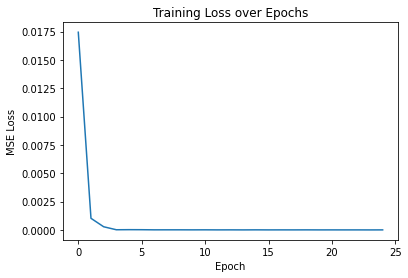

In [26]:
# Initializing Hyperparameters
train_losses = []
test_losses = []

# Loop over the number of epochs
for epoch in range(num_epochs):
    train_loss = 0
    # Initialize the hidden state and the cell state
    # The hidden state and the cell state reset to zero for every epoch
    hs = torch.zeros(1, hidden_size)
    cs = torch.zeros(1, hidden_size)

    # Get the input and target at position i
    for i, (data, label) in enumerate(train_loader):
        
        hidden = (hs, cs)
        # Run the forward pass
        output, hidden = lstm(data.float(), hidden)
        output = fc(hidden[-1])
        hs = hs.detach()
        cs = cs.detach()

        # 2. Network Evaluation
        loss = criterion(output, label.float())

        # 3. Gradient Calculation
        loss.backward()

        # 4. Back Propagation
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()

    # Calculate the average training loss
    train_loss = train_loss / len(train_loader)
    train_losses.append(train_loss)

# Plot the MSE loss for each epoch
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss over Epochs')
plt.show()

In [27]:
# Evaluate the LSTM model
mse = 0

#By wrapping the evaluation code in a with torch.no_grad() context, 
#you can avoid unnecessary memory usage and speed up the evaluation process.
with torch.no_grad():
    # Initialize the hidden state and the cell state
    # The hidden state and the cell state reset to zero for every epoch
    hs = torch.zeros(1, hidden_size)
    cs = torch.zeros(1, hidden_size)

    for data, label in test_loader:
        hidden = (hs, cs)
        output, hidden = lstm(data.float(), hidden)
        output = fc(hidden[-1])
        hs = hs.detach()
        cs = cs.detach()
        
        mse += ((output - label)**2).mean().item()

mse /= len(test_loader)
print('Test MSE: {}'.format(mse))

Test MSE: 1.593499560137182e-05


In [28]:
output_list = []

# Initialize the hidden state and the cell state
# The hidden state and the cell state reset to zero for every epoch
hs = torch.zeros(1, hidden_size)
cs = torch.zeros(1, hidden_size)
for i, (data, label) in enumerate(test_loader):
    hidden = (hs, cs)
    
    # Run the forward pass
    output, hidden = lstm(data.float(), hidden)
    output = fc(hidden[-1])
    hs = hs.detach()
    cs = cs.detach()
    output_list.append(output.detach().numpy()[0][0])
    
for i, (data, label) in enumerate(train_loader):
    hidden = (hs, cs)

    # Run the forward pass
    output, hidden = lstm(data.float(), hidden)
    output = fc(hidden[-1])
    hs = hs.detach()
    cs = cs.detach()
    output_list.append(output.detach().numpy()[0][0])

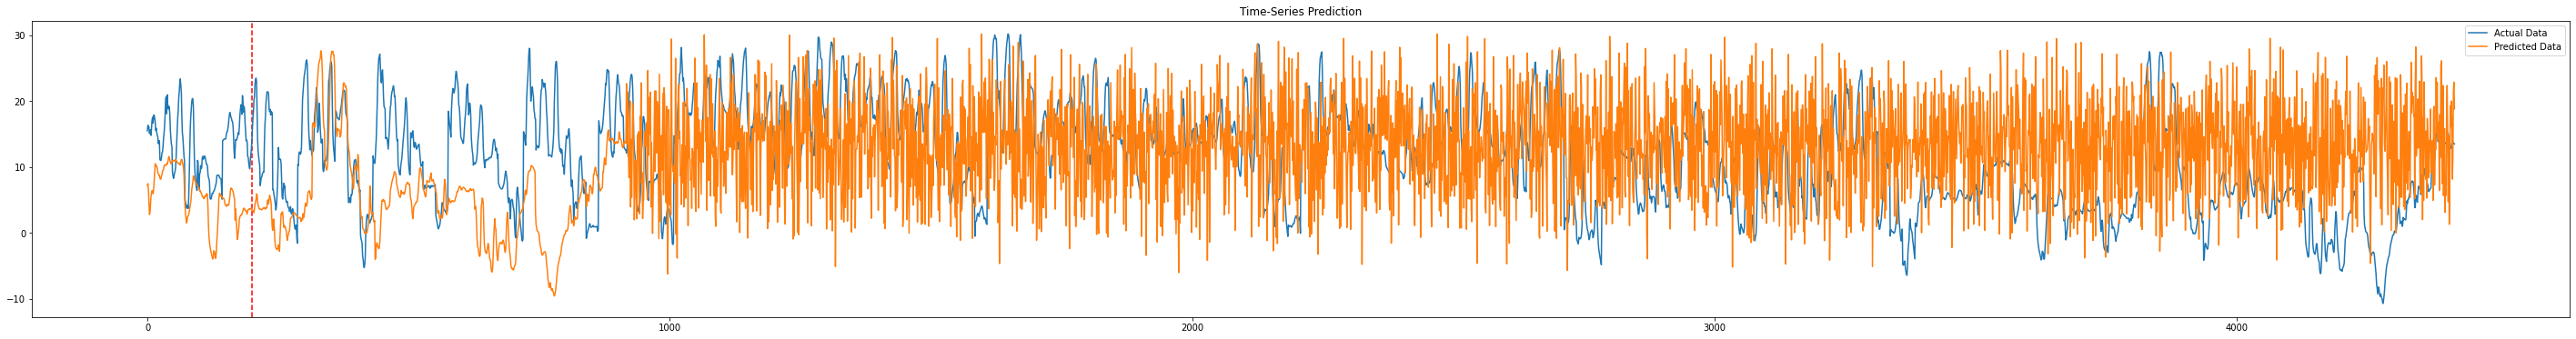

In [29]:
# Plotting the actual values vs. the predicted values
dataY_plot = y['T (degC)'].values
data_predict = mm.inverse_transform([output_list]) #reverse transformation
plt.figure(figsize=(50,6)) #plotting
plt.axvline(x=200, c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actual Data') #actual plot
plt.plot(data_predict[0], label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 

In [30]:
# Save the trained RNN model
torch.save(lstm.state_dict(), 'lstm_exp_3.pt')

# Load the model
lstm_exp_3 = nn.LSTM(input_size, hidden_size, batch_first=True)
lstm_exp_3.load_state_dict(torch.load('lstm_exp_3.pt'))

<All keys matched successfully>

## Experiment 4

Hyperparameters:
- Hidden size = 20
- Number of epochs = 25
- Loss function = MSE Loss
- Optimization algorithm = RMSprop
- Learning rate = 0.001


In [31]:
# Initialize the LSTM model
# Define the input size, hidden size and number of outputs
input_size = 5
hidden_size = 20
output_size = 1
num_epochs= 25

# Define the LSTM model and Linear output fully connected layer
lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
fc = nn.Linear(hidden_size, output_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.RMSprop(lstm.parameters(), lr=0.001)

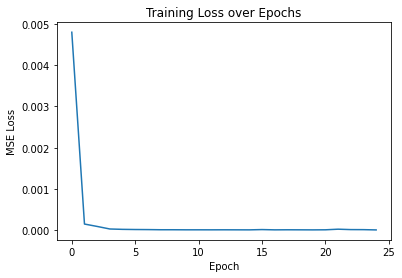

In [32]:
# Initializing Hyperparameters
train_losses = []
test_losses = []

# Loop over the number of epochs
for epoch in range(num_epochs):
    train_loss = 0
    # Initialize the hidden state and the cell state
    # The hidden state and the cell state reset to zero for every epoch
    hs = torch.zeros(1, hidden_size)
    cs = torch.zeros(1, hidden_size)

    # Get the input and target at position i
    for i, (data, label) in enumerate(train_loader):
        
        hidden = (hs, cs)
        # Run the forward pass
        output, hidden = lstm(data.float(), hidden)
        output = fc(hidden[-1])
        hs = hs.detach()
        cs = cs.detach()

        # 2. Network Evaluation
        loss = criterion(output, label.float())

        # 3. Gradient Calculation
        loss.backward()

        # 4. Back Propagation
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()

    # Calculate the average training loss
    train_loss = train_loss / len(train_loader)
    train_losses.append(train_loss)

# Plot the MSE loss for each epoch
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss over Epochs')
plt.show()

In [33]:
# Evaluate the LSTM model
mse = 0

#By wrapping the evaluation code in a with torch.no_grad() context, 
#you can avoid unnecessary memory usage and speed up the evaluation process.
with torch.no_grad():
    # Initialize the hidden state and the cell state
    # The hidden state and the cell state reset to zero for every epoch
    hs = torch.zeros(1, hidden_size)
    cs = torch.zeros(1, hidden_size)

    for data, label in test_loader:
        hidden = (hs, cs)
        output, hidden = lstm(data.float(), hidden)
        output = fc(hidden[-1])
        hs = hs.detach()
        cs = cs.detach()
        
        mse += ((output - label)**2).mean().item()

mse /= len(test_loader)
print('Test MSE: {}'.format(mse))

Test MSE: 1.4278545079196007e-05


In [34]:
output_list = []

# Initialize the hidden state and the cell state
# The hidden state and the cell state reset to zero for every epoch
hs = torch.zeros(1, hidden_size)
cs = torch.zeros(1, hidden_size)
for i, (data, label) in enumerate(test_loader):
    hidden = (hs, cs)
    
    # Run the forward pass
    output, hidden = lstm(data.float(), hidden)
    output = fc(hidden[-1])
    hs = hs.detach()
    cs = cs.detach()
    output_list.append(output.detach().numpy()[0][0])
    
for i, (data, label) in enumerate(train_loader):
    hidden = (hs, cs)

    # Run the forward pass
    output, hidden = lstm(data.float(), hidden)
    output = fc(hidden[-1])
    hs = hs.detach()
    cs = cs.detach()
    output_list.append(output.detach().numpy()[0][0])

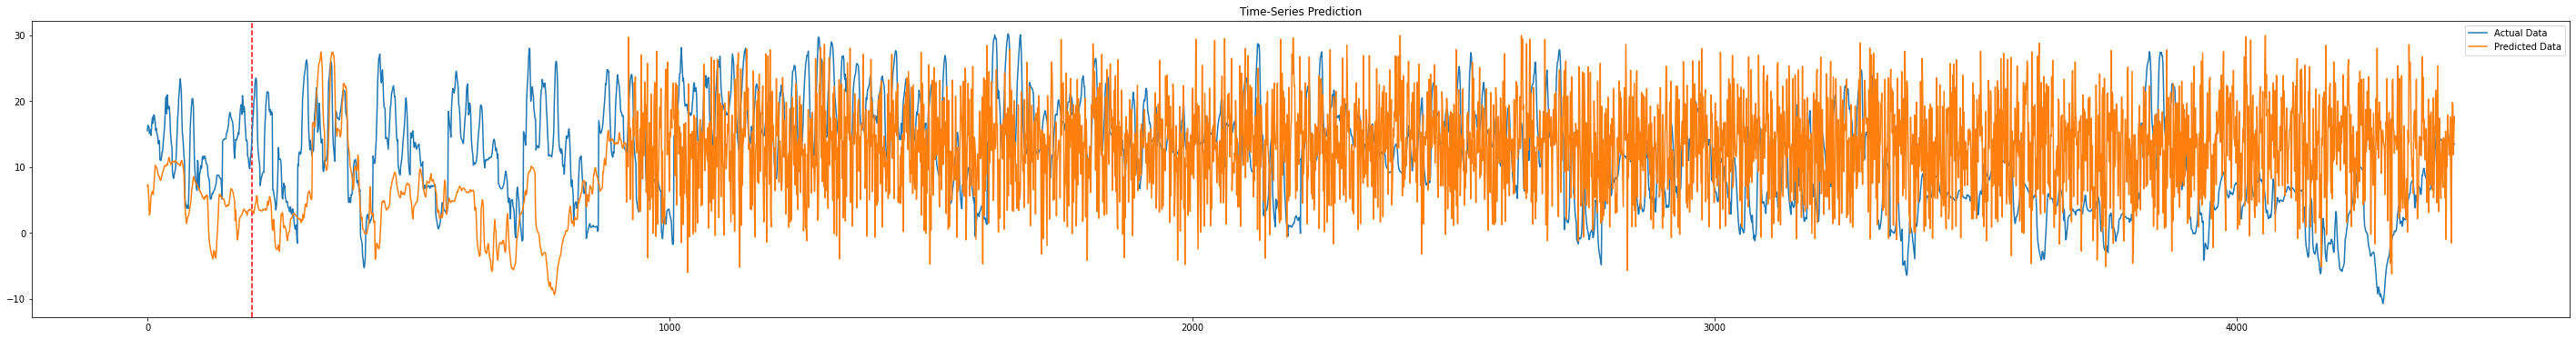

In [35]:
# Plotting the actual values vs. the predicted values
dataY_plot = y['T (degC)'].values
data_predict = mm.inverse_transform([output_list]) #reverse transformation
plt.figure(figsize=(50,6)) #plotting
plt.axvline(x=200, c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actual Data') #actual plot
plt.plot(data_predict[0], label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 

In [36]:
# Save the trained RNN model
torch.save(lstm.state_dict(), 'lstm_exp_4.pt')

# Load the model
lstm_exp_4 = nn.LSTM(input_size, hidden_size, batch_first=True)
lstm_exp_4.load_state_dict(torch.load('lstm_exp_4.pt'))

<All keys matched successfully>